
Training with Xavier Initialization:
XAVIER - Epoch [1/10] - Loss: 0.6985 - Val Loss: 0.7041 - Accuracy: 0.4250
XAVIER - Epoch [2/10] - Loss: 0.6941 - Val Loss: 0.7010 - Accuracy: 0.4250
XAVIER - Epoch [3/10] - Loss: 0.6935 - Val Loss: 0.6993 - Accuracy: 0.4250
XAVIER - Epoch [4/10] - Loss: 0.6930 - Val Loss: 0.6957 - Accuracy: 0.4250
XAVIER - Epoch [5/10] - Loss: 0.6930 - Val Loss: 0.6946 - Accuracy: 0.5250
XAVIER - Epoch [6/10] - Loss: 0.6925 - Val Loss: 0.6950 - Accuracy: 0.4750
XAVIER - Epoch [7/10] - Loss: 0.6922 - Val Loss: 0.6962 - Accuracy: 0.4500
XAVIER - Epoch [8/10] - Loss: 0.6918 - Val Loss: 0.6964 - Accuracy: 0.4500
XAVIER - Epoch [9/10] - Loss: 0.6917 - Val Loss: 0.6949 - Accuracy: 0.4250
XAVIER - Epoch [10/10] - Loss: 0.6913 - Val Loss: 0.6967 - Accuracy: 0.4000

Training with He Initialization:
HE - Epoch [1/10] - Loss: 0.6954 - Val Loss: 0.6924 - Accuracy: 0.5250
HE - Epoch [2/10] - Loss: 0.6909 - Val Loss: 0.6863 - Accuracy: 0.5500
HE - Epoch [3/10] - Loss: 0.6890 - 

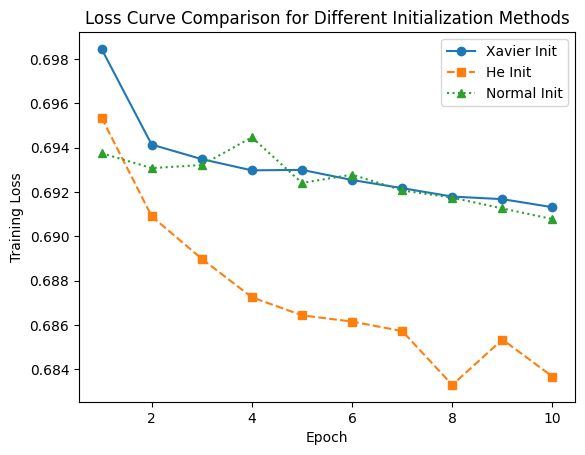

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the MLP Model
class MLP(nn.Module):
    def __init__(self, init_type="xavier"):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(3, 8)
        self.hidden2 = nn.Linear(8, 8)
        self.output = nn.Linear(8, 1)  # Scalar output
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # Apply initialization
        self.init_weights(init_type)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.sigmoid(self.output(x))
        return x

    def init_weights(self, init_type):
        for layer in [self.hidden1, self.hidden2, self.output]:
            if init_type == "xavier":
                nn.init.xavier_uniform_(layer.weight)
            elif init_type == "he":
                nn.init.kaiming_uniform_(layer.weight, nonlinearity="relu")
            elif init_type == "normal":
                nn.init.normal_(layer.weight, mean=0, std=0.1)
            layer.bias.data.fill_(0)  # Set biases to zero

# Generate synthetic dataset
np.random.seed(42)
torch.manual_seed(42)

X = np.random.rand(200, 3).astype(np.float32)  # 200 samples, 3 features
y = np.random.randint(0, 2, (200, 1)).astype(np.float32)  # 200 binary labels

# Convert to PyTorch tensors
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

# Split dataset (80% Train, 20% Validation)
train_size = int(0.8 * len(X))
X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]

# Training function
def train_and_evaluate(init_type):
    model = MLP(init_type)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    epochs = 10
    batch_size = 20
    loss_values = []

    for epoch in range(epochs):
        permutation = torch.randperm(X_train.size(0))  # Shuffle dataset
        epoch_loss = 0

        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Compute validation loss & accuracy
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            predicted_labels = (val_outputs > 0.5).float()
            accuracy = (predicted_labels == y_val).float().mean().item()

        avg_loss = epoch_loss / (X_train.size(0) / batch_size)
        loss_values.append(avg_loss)

        print(f"{init_type.upper()} - Epoch [{epoch + 1}/10] - Loss: {avg_loss:.4f} - Val Loss: {val_loss:.4f} - Accuracy: {accuracy:.4f}")

    return loss_values

# Train models with different initialization methods
print("\nTraining with Xavier Initialization:")
loss_xavier = train_and_evaluate("xavier")

print("\nTraining with He Initialization:")
loss_he = train_and_evaluate("he")

print("\nTraining with Normal Initialization:")
loss_normal = train_and_evaluate("normal")

# Plot Loss Curve Comparison
plt.plot(range(1, 11), loss_xavier, marker='o', linestyle='-', label="Xavier Init")
plt.plot(range(1, 11), loss_he, marker='s', linestyle='--', label="He Init")
plt.plot(range(1, 11), loss_normal, marker='^', linestyle=':', label="Normal Init")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve Comparison for Different Initialization Methods")
plt.legend()
plt.show()
